In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
survey = fetch_openml(data_id=534, as_frame=True)

In [6]:
survey.data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


In [7]:
survey.data.describe()


,EDUCATION,EXPERIENCE,AGE
count,534.000000,534.000000,534.000000
mean,13.018727,17.822097,36.833333
std,2.615373,12.379710,11.726573
min,2.000000,0.000000,18.000000
25%,12.000000,8.000000,28.000000
50%,12.000000,15.000000,35.000000
75%,15.000000,26.000000,44.000000
max,18.000000,55.000000,64.000000


In [9]:
survey.target

0       5.10
1       4.95
2       6.67
3       4.00
4       7.50
       ...  
529    11.36
530     6.10
531    23.25
532    19.88
533    15.38
Name: WAGE, Length: 534, dtype: float64

In [10]:
X = survey.data.copy()
y = survey.target.copy()


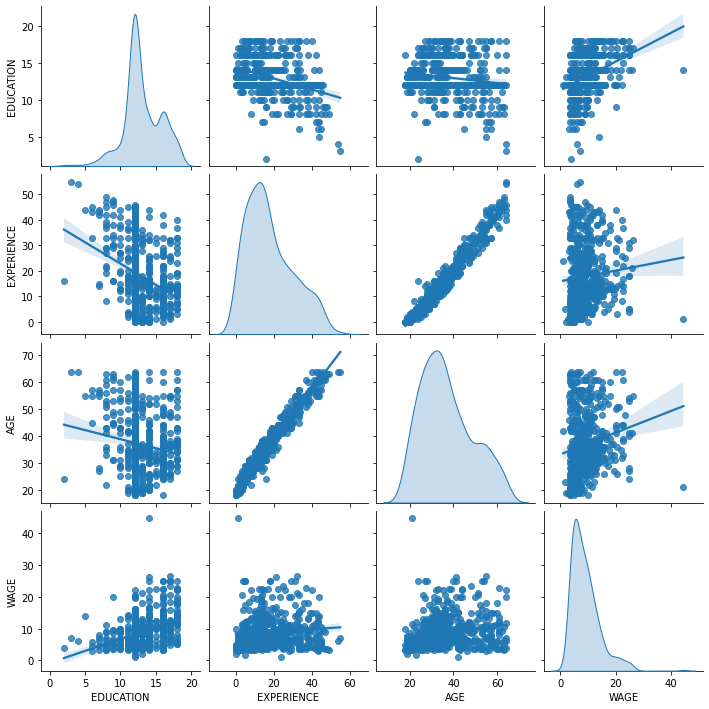

In [19]:
data_full = X.copy()
data_full['WAGE'] = y.copy()
sns.pairplot(data_full , kind="reg", diag_kind="kde")

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = ["SOUTH", "SEX", "UNION", "RACE", "OCCUPATION", "SECTOR", "MARR"]
numerical_features = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_features),
    remainder="passthrough",
    verbose_feature_names_out=False
)


In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
import scipy as sp

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)
)

In [21]:
_ = model.fit(X_train, y_train)


In [22]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

22.34254887383752

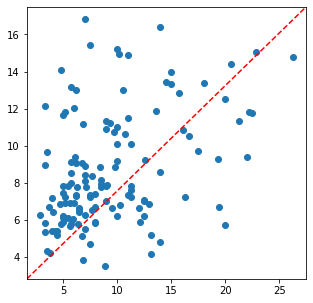

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

In [45]:
features_fitted = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(data=model.named_steps['transformedtargetregressor'].regressor_.coef_, columns=["Coefficients"], index=features_fitted)
coefs

,Coefficients
SOUTH_yes,-0.043983
SEX_male,0.106870
UNION_not_member,-0.116704
RACE_Hispanic,-0.012928
RACE_Other,-0.019519
RACE_White,0.032465
OCCUPATION_Clerical,0.026133
OCCUPATION_Management,0.083200
OCCUPATION_Other,-0.028947
OCCUPATION_Professional,0.054963


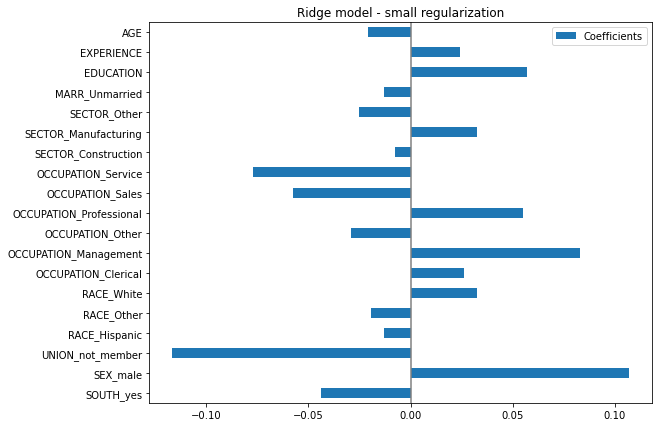

In [49]:
coefs.plot(kind="barh", figsize=(9,7))
plt.title("Ridge model - small regularization")
plt.axvline(x=0, color=".5")

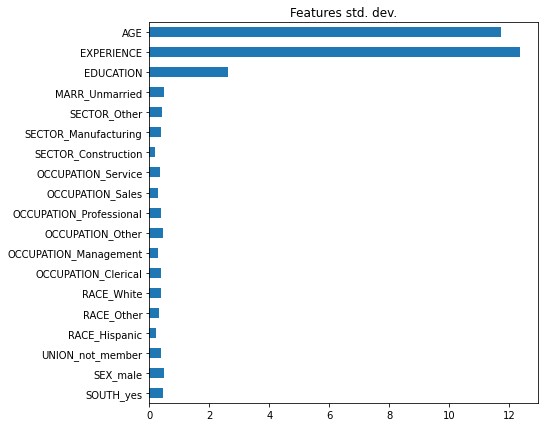

In [51]:
# Calculate standard deviaation of features
X_train_preprocessed = pd.DataFrame(
    model.named_steps["columntransformer"].transform(X_train), columns=features_fitted
)

X_train_preprocessed.std(axis=0).plot(kind="barh", figsize=(9, 7))
plt.title("Features std. dev.")
plt.subplots_adjust(left=0.3)

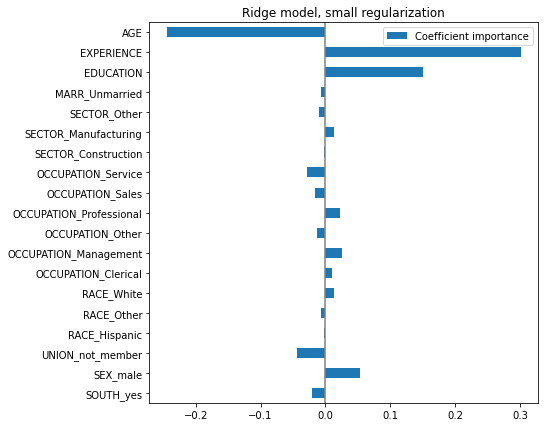

In [52]:
# The features when rescaled by their standard deviation
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_
    * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=features_fitted,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [55]:
# Try Lasso to fit sparse model
from sklearn.linear_model import LassoCV

lasso_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(regressor=LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=10000000), func=np.log10, inverse_func=sp.special.exp10)
)
_ = lasso_model.fit(X_train, y_train)

In [59]:
lasso_model[-1].regressor_.alpha_

0.001

In [60]:
y_pred_lasso = lasso_model.predict(X_test)
mean_squared_error(y_test, y_pred_lasso)

22.32759819101772

In [67]:
features_fitted_lasso = lasso_model[:-1].get_feature_names_out()

coefs_lasso = pd.DataFrame(data=lasso_model[-1].regressor_.coef_, columns=["Coefficiens_Lasso"], index=features_fitted_lasso)

In [68]:
coefs_lasso

,Coefficiens_Lasso
SOUTH_yes,-0.042192
SEX_male,0.098200
UNION_not_member,-0.107561
RACE_Hispanic,0.000000
RACE_Other,-0.000469
RACE_White,0.040425
OCCUPATION_Clerical,0.031405
OCCUPATION_Management,0.085397
OCCUPATION_Other,-0.000000
OCCUPATION_Professional,0.061921


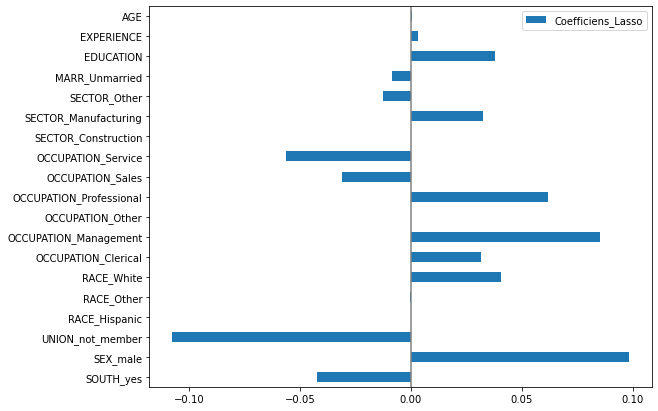

In [71]:
coefs_lasso.plot(kind="barh", figsize=(9,7))
plt.axvline(0, color="0.5")